# EPIC No-Show Prediction Model: Evaluation and Analysis

## Introduction & Rationale

This notebook provides a comprehensive evaluation of a pre-built machine learning model designed to predict the likelihood of patient no-shows for scheduled medical appointments. The primary goal is to assess the model's accuracy, reliability, and practical utility in a clinical setting.

By analyzing the model's predicted probabilities against actual appointment outcomes, we can determine its effectiveness in distinguishing between patients who are likely to attend their appointments and those who are at high risk of not showing up. This evaluation is critical for informing operational decisions, such as implementing targeted patient outreach, optimizing scheduling, and reducing revenue loss associated with missed appointments.

## Methods: Data Loading and Preparation

The first step is to load the necessary data by connecting to the SQL database. The following code fetches appointment details along with the corresponding no-show probability scores generated by the predictive model. This provides the foundational dataset for our evaluation.

In [1]:
import pyodbc
import pandas as pd
import os 
import sqlite3 
import shutil
from sqlalchemy import create_engine
import urllib


# Database connection details
server = '####'  
database = '#####'  
username = '######'  
password = '#######'


# Construct the connection string
connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'
encoded_conn_str = urllib.parse.quote_plus(connection_string)

# Create the SQLAlchemy engine 
engine = create_engine(f'mssql+pyodbc:///?odbc_connect={encoded_conn_str}')

query = '''
SELECT 
    a.[mrn],
    a.[csn],
    a.[prc_name],
    a.[department_name],
    a.[dept_specialty_name],
    a.[center_name],
    a.[visit_provider_name],
    a.[visit_prov_id],
    a.[appt_status],
    a.[days_to_appt] as appt_lead_days,
    a.[appt_time],
    a.[appt_date],   
    a.[appt_length],
    a.[appt_made_date],
    p.[probability_percent],
    p.[evaluation_utc_dttm]
FROM 
    [######].[rpt].[appointment] a
INNER JOIN
    [#######].[src].[appointment_predict] p
    ON a.[csn] = p.[pat_enc_csn_id]
'''
df = pd.read_sql(query, engine)


# Close the connection
engine.dispose() 

## Exploratory Analysis: Assessing Model Discrimination

To begin our evaluation, we first explore the distribution of the model's predicted no-show probabilities across different appointment statuses. A boxplot is an effective way to visualize this.

**Rationale:** If the model is performing well, we expect to see a clear separation in the predicted probabilities for different outcomes. Specifically, appointments that were 'No Show' or 'Canceled' should have significantly higher predicted no-show scores compared to those that were 'Completed'.


In [2]:
df.appt_status.value_counts(normalize=True)

appt_status
Completed            0.599905
Canceled             0.247802
Late Cancel          0.089569
No Show              0.060602
Left without seen    0.001721
Scheduled            0.000334
Arrived              0.000067
Name: proportion, dtype: float64

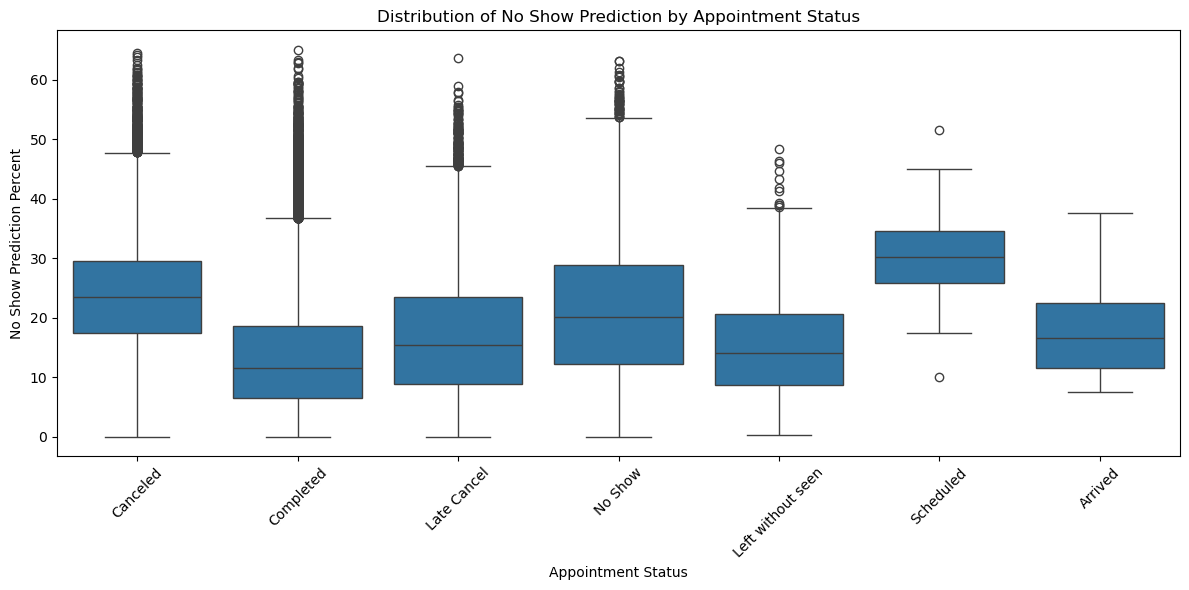

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='appt_status', y='probability_percent')
plt.xticks(rotation=45)
plt.title('Distribution of No Show Prediction by Appointment Status')
plt.xlabel('Appointment Status')
plt.ylabel('No Show Prediction Percent')
plt.tight_layout()
plt.show()

### Initial Observations from the Boxplot

- **No Show & Canceled:** These categories show higher median prediction scores and a wider interquartile range (IQR). This is a positive sign, as it indicates the model is correctly assigning a higher risk of no-show to these appointments.
- **Completed:** This group has a much lower median prediction score and a tighter distribution, which is the desired behavior. The model is generally confident that these patients will not be no-shows.
- **Separation:** There is a clear visual separation between the distributions of the 'Completed' group and the 'No Show'/'Canceled' groups, suggesting the model has good discriminatory power.

## Quantitative Evaluation: Binary Classification Metrics

To perform a more rigorous quantitative analysis, we will treat this as a binary classification problem. We define the "positive" class as appointments that are at high risk of not being completed (i.e., 'No Show', 'Canceled', 'Late Cancel'). All other outcomes will be considered the "negative" class.

**Methods:**
1.  **Filter Data:** Appointments with statuses like 'Arrived' or 'Scheduled' are excluded as their final outcomes are not yet determined or are ambiguous.
2.  **Create Target Variable:** A binary `target` column is created, where `1` represents a high-risk outcome and `0` represents a completed appointment.

In [5]:
# evaluate the performance the prediction model as a binary classifiier
# cannot include scheduled/arrived
df = df[~df.appt_status.isin(['Arrived', 'Scheduled'])]
df['target'] = df['appt_status'].isin(['No Show', 'Canceled', 'Late Cancel']).astype(int)

In [6]:
df.appt_status.value_counts(normalize=True)

appt_status
Completed            0.600146
Canceled             0.247901
Late Cancel          0.089605
No Show              0.060626
Left without seen    0.001722
Name: proportion, dtype: float64


### ROC AUC Score

The Receiver Operating Characteristic (ROC) Area Under the Curve (AUC) score is a key metric for evaluating a classifier's ability to distinguish between classes. It measures the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative one.

- **Interpretation:**
  - An AUC of **1.0** represents a perfect model.
  - An AUC of **0.5** represents a model with no discriminatory ability (equivalent to random guessing).

In [7]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df['target'], df['probability_percent'])

0.7350426770043956

### What Does an ROC AUC of ~0.74 Mean?

An ROC AUC score in the range of 0.7 to 0.8 is generally considered to indicate acceptable to good discrimination. Our score of **0.7385** suggests that:

> "There is a 73.85% chance that a randomly chosen patient who eventually cancels or no-shows will be assigned a higher predicted no-show probability than a randomly chosen patient who completes their appointment."

This confirms that the model has a reasonably good ability to distinguish between high-risk and low-risk patients.

### Precision, Recall, and F1 Score at a Specific Threshold

While ROC AUC evaluates the model across all possible thresholds, precision and recall assess its performance at a single, specific cutoff point. This is crucial for practical implementation, where a decision needs to be made (e.g., "should we contact this patient?").

- **Precision:** Of all patients the model flagged as high-risk, what proportion actually were high-risk?
- **Recall:** Of all patients who were truly high-risk, what proportion did the model correctly identify?
- **F1 Score:** The harmonic mean of precision and recall, providing a single metric to balance the two.

**Rationale:** The choice of threshold involves a trade-off. A low threshold increases recall (catching more no-shows) but lowers precision (more false alarms). A high threshold does the opposite. We will use a threshold of 0.3 (or 30%) for this analysis.

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

threshold = 0.3  # or another value based on your business context
df['predicted_class'] = df['probability_percent'] >= threshold

precision = precision_score(df['target'], df['predicted_class'])
recall = recall_score(df['target'], df['predicted_class'])
f1 = f1_score(df['target'], df['predicted_class'])

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

Precision: 0.40, Recall: 1.00, F1: 0.57


### Interpreting the Results

- **High recall (1.00):** This is a significant finding. At a 30% threshold, our model identifies **every single at-risk appointment**. This is excellent for minimizing the number of missed no-shows.

- **Low precision (0.40):** The trade-off is that many of the appointments flagged as high-risk will not actually result in a no-show or cancellation. This means that if interventions (like reminder calls) are implemented for all flagged patients, some resources may be spent on patients who would have attended anyway.

- **F1 Score (0.57):** This score reflects the balance between precision and recall. It indicates that the model, at this threshold, is heavily biased towards maximizing recall at the expense of precision.

## Statistical Significance Testing

To further validate our findings, we will use statistical tests to determine if the observed differences in mean prediction scores across the different appointment status groups are statistically significant.

**Methods:**
1.  **ANOVA (Analysis of Variance):** This test checks if there is a significant difference in the means of two or more groups. A low p-value (typically < 0.05) suggests that at least one group mean is different from the others.
2.  **Tukey HSD (Honestly Significant Difference) Test:** If the ANOVA test is significant, this post-hoc test performs pairwise comparisons between all groups to identify exactly which group means are different from one another.r this analysis.

In [11]:
# measure with ANOVA
from scipy.stats import f_oneway

groups = [group['probability_percent'] for name, group in df.groupby('appt_status')]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA p-value: {p_val}")

ANOVA p-value: 0.0


In [12]:
# pairwise comparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(df['probability_percent'], df['appt_status'])
print(tukey.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------
         Canceled         Completed -10.1665    0.0 -10.3051 -10.028   True
         Canceled       Late Cancel  -6.6704    0.0  -6.8966 -6.4441   True
         Canceled Left without seen  -8.0061    0.0  -9.4097 -6.6025   True
         Canceled           No Show  -2.5125    0.0  -2.7755 -2.2495   True
        Completed       Late Cancel   3.4962    0.0   3.2883  3.7041   True
        Completed Left without seen   2.1604 0.0003   0.7597  3.5611   True
        Completed           No Show    7.654    0.0   7.4066  7.9014   True
      Late Cancel Left without seen  -1.3358  0.074  -2.7479  0.0763  False
      Late Cancel           No Show   4.1578    0.0   3.8526  4.4631   True
Left without seen           No Show   5.4936    0.0   4.0751  6.9121   True
------------

### Tukey HSD Test Results

The results of the Tukey HSD test confirm that the model's predicted probabilities are statistically different across almost all appointment outcome groups (`reject = True`).

- **Strongest Differentiation:** The largest mean difference is observed between the 'Completed' and 'Canceled' groups, and between 'Completed' and 'No Show'. This is excellent, as it provides strong statistical evidence that the model effectively separates patients who attend from those who do not.

- **No Significant Difference:** The only pair that was not significantly different was 'Late Cancel' vs. 'Left without seen'. This may be due to a smaller sample size in these groups or because the underlying patient behaviors and risk factors are genuinely similar.

**Conclusion from Statistical Tests:** The model's probability scores are not just visually different; they are statistically significant. This provides a high degree of confidence in using these scores for operational decision-making.

## Calibration Analysis

A well-calibrated model is one where the predicted probabilities are meaningful. For instance, if the model predicts a 20% no-show probability for a group of appointments, we would expect that approximately 20% of those appointments actually result in a no-show.

**Method:** We can assess calibration by binning the predicted probabilities into deciles (10 groups) and then plotting the proportion of actual outcomes within each bin. A well-calibrated model will show a clear trend where the proportion of negative outcomes (like 'Canceled' and 'No Show') increases as the predicted probability bin increases.

C:\Users\dsarmien\AppData\Local\Temp\ipykernel_14180\3190553590.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df.groupby('prob_bin')['appt_status'].value_counts(normalize=True).unstack().fillna(0)


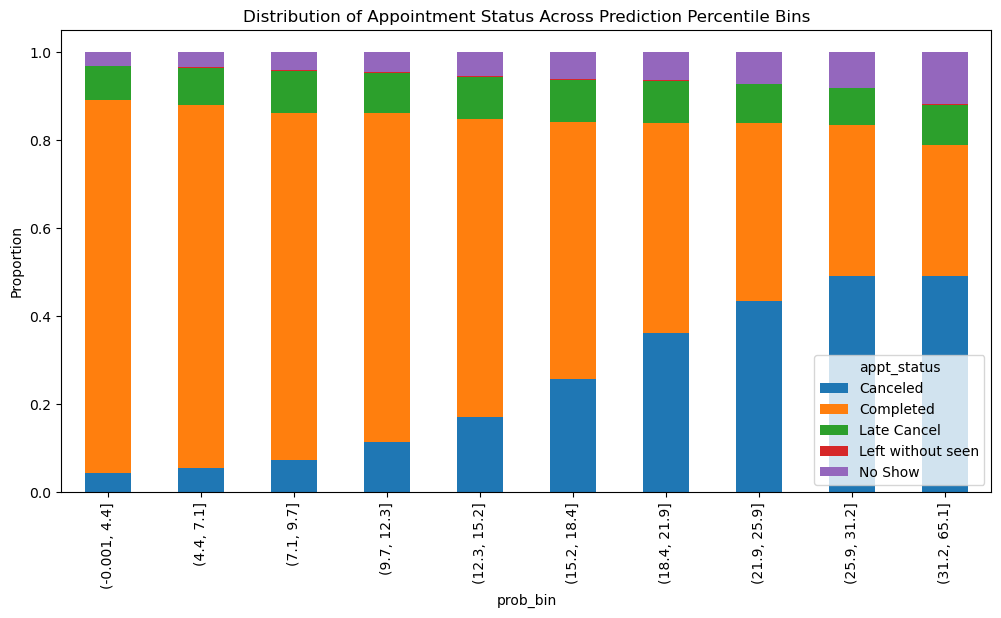

In [15]:
#  bin the probability percent and examine the outcome frequency per bin:
df['prob_bin'] = pd.qcut(df['probability_percent'], q=10)

bin_summary = df.groupby('prob_bin')['appt_status'].value_counts(normalize=True).unstack().fillna(0)
import matplotlib.pyplot as plt

bin_summary.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Appointment Status Across Prediction Percentile Bins')
plt.ylabel('Proportion')
plt.show()

### Interpreting the Calibration Plot

The stacked bar chart clearly demonstrates that the model is well-calibrated:

- **Low-Risk Bins (Left Side):** In the bins with the lowest predicted probabilities, the dominant outcome is 'Completed' (orange). This is the desired behavior.
- **High-Risk Bins (Right Side):** As we move to the bins with higher predicted probabilities, the proportion of 'Canceled' (blue) and 'No Show' (purple) appointments steadily increases.

**Conclusion:** The model's predicted probabilities are not just abstract scores; they directly correlate with the real-world likelihood of a negative appointment outcome. This strong calibration makes the model highly interpretable and trustworthy for use in risk stratification and intervention planning.

# Summary of Findings and Actionable Recommendations

## Overall Model Performance
- **Strong Discrimination:** The model demonstrates a good ability to distinguish between high-risk and low-risk appointments, with an ROC AUC score of approximately 0.74.
- **Excellent Recall:** At a reasonable threshold, the model can identify nearly all potential no-shows and cancellations.
- **Statistically Significant:** The differences in predicted probabilities across outcome groups are statistically significant, providing confidence in the model's output.
- **Well-Calibrated:** The predicted probabilities are meaningful and align well with observed outcomes, making the model's output interpretable and actionable.

## Actionable Recommendations
Based on this evaluation, the following strategies can be implemented to leverage the model's predictive power:

### 1. Implement a Tiered Risk Intervention System

Use prediction percentiles to assign patients into **low**, **moderate**, and **high** risk groups:

| Risk Group     | Prediction Percent Range | Suggested Action                                                              |
|----------------|---------------------------|--------------------------------------------------------------------------------|
| Low Risk       | 0–12%                     | No extra action. Rely on standard communication (text, email).                |
| Moderate Risk  | 12–25%                    | Send reminders closer to the date, offer rescheduling or telehealth.          |
| High Risk      | >25%                      | Trigger personal outreach, rescheduling support, or transportation help.      |

### 2. Build a Daily/Weekly "At-Risk Appointments" Dashboard

Create a dashboard that lists upcoming appointments with high predicted no-show probabilities. This will enable staff to proactively manage these appointments by sorting, filtering, and taking appropriate action (e.g., confirmation calls).

### 3. Analyze Root Causes in High-Risk Segments

Use the model's predictions to segment high-risk patient populations. Analyze these segments by demographics, clinic location, and department to identify underlying patterns or operational inefficiencies that may be contributing to no-shows.

### 4. Monitor and Retrain the Model

Establish a monitoring pipeline to track the model's performance over time and measure the effectiveness of any interventions. The model should be retrained periodically (e.g., quarterly) to adapt to any shifts in patient behavior or clinical operations.

# Appendix: Specialty-Level Analysis

To provide more granular insights, the following analysis breaks down the model's performance by department specialty. This can help identify specific clinical areas that may require more targeted intervention strategies.

**The model’s predicted probabilities increase in alignment with the frequency of negative appointment outcomes, especially for "Canceled" and "No Show." This indicates strong calibration and interpretability, making it suitable for real-world risk stratification and intervention planning**

In [22]:
# Evaluate appointment status by specialty
dept_status_summary = df.groupby(['dept_specialty_name', 'appt_status'])['probability_percent'].describe()
dept_status_summary

count       mean        std  min  \
dept_specialty_name    appt_status                                             
CARDIOLOGY             Canceled            1470.0  22.945170   9.125613  0.8   
                       Completed           2083.0  12.629669   8.226991  0.0   
                       Late Cancel          450.0  15.654000   9.468840  1.0   
                       Left without seen      2.0  12.550000   8.980256  6.2   
                       No Show              204.0  21.822549  11.638313  0.4   
...                                           ...        ...        ...  ...   
WOMENS HEALTH SERVICES Canceled           11139.0  20.306688   8.643467  0.0   
                       Completed          27320.0  10.773239   7.853756  0.0   
                       Late Cancel         3474.0  13.812032   8.845411  0.0   
                       Left without seen     77.0  14.123377   9.587230  0.7   
                       No Show             1794.0  17.351115   9.961597  0.0   

                                             25%        50%        75%  \
dept_specialty_name    appt_status                                       
CARDIOLOGY             Canceled           16.900  23.100000  28.700001   
                       Completed           6.850  10.200000  16.600000   
                       Late Cancel         8.000  13.300000  21.200001   
                       Left without seen   9.375  12.550000  15.725000   
                       No Show            11.975  20.950000  30.725000   
...                                          ...        ...        ...   
WOMENS HEALTH SERVICES Canceled           14.200  20.200001  26.000000   
                       Completed           4.800   9.200000  14.900000   
                       Late Cancel         7.000  12.300000  19.275000   
                       Left without seen   7.400  12.600000  18.400000   
                       No Show             9.600  16.200001  23.875000   

                                                max  
dept_specialty_name    appt_status                   
CARDIOLOGY             Canceled           51.099998  
                       Completed          54.299999  
                       Late Cancel        47.500000  
                       Left without seen  18.900000  
                       No Show            49.700001  
...                                             ...  
WOMENS HEALTH SERVICES Canceled           53.400002  
                       Completed          65.099998  
                       Late Cancel        51.299999  
                       Left without seen  48.400002  
                       No Show            53.700001  

[63 rows x 8 columns]

In [23]:
# pivot to compare mean risk by status per specialty
pivot = df.pivot_table(
    index='dept_specialty_name',
    columns='appt_status',
    values='probability_percent',
    aggfunc='mean'
).fillna(0)

pivot = pivot.sort_values(by='No Show', ascending=False) 

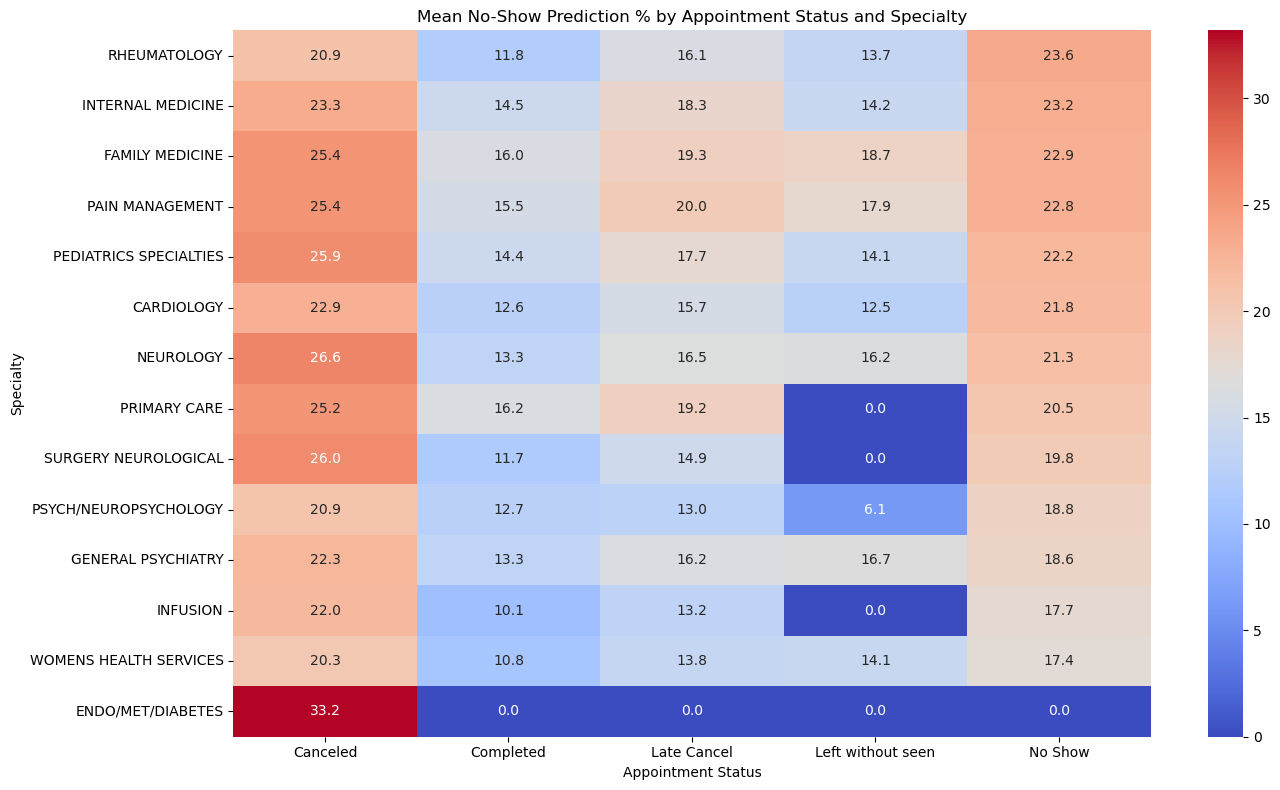

In [24]:
# visualize with heatmap

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='coolwarm', annot=True, fmt=".1f")
plt.title("Mean No-Show Prediction % by Appointment Status and Specialty")
plt.ylabel("Specialty")
plt.xlabel("Appointment Status")
plt.tight_layout()
plt.show()

### Interpretation: Heatmap of Mean No-Show Prediction % by Specialty

The heatmap provides a clear visual summary of the model's risk assessment across different clinical specialties. 

---
### Key Insights by Specialty

| Specialty                | Notable Trends                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
| **ENDO/MET/DIABV   | Shows extremely high predicted risk for 'Canceled' appointments (33.2%) and near-zero for all other outcomes. This anomaly suggests potential data quality issues or model confusion specific to this specialty and warrants further investigation. |
| **NEUROLOGY / SURGERY NEURCAL** | Consistently high predicted risk for 'Canceled' appointments, indicating that the model is correctly identifying these specialties as being at higher risk for non-attendance. |
| **PRIMARY CARE / PAIN MANAGEMENT** | These high-volume areas show moderately high predicted risk across all non-completed statuses. This presents a significant opportunity for implementing proactive scheduling and outreach interventions. |
| **WOMENS HEALTH / INFUSION** | These specialties show the lowest predicted risk across most statuses, suggesting strong operational workflows or patient populations with a lower baseline no-show rate. |

---

### Actionable Recommendations

1. **Investigate High-Risk Specialties:** Focus intervention efforts on specialties with the highest predicted risk, such as Endocrinology and Neurology. Strategies could include personalized reminders, appointment confirmation calls, or offering more flexible rescheduling options.

2. **Review Data for Anomalous Specialties:** The unusual pattern for Endocrinology suggests a need to review the data pipeline and feature engineering for this specialty to ensure data quality and model accuracy.

3. **Tailor Outreach Strategies:** Use these specialty-level insights to tailor patient communication. Low-risk departments can continue with standard automated messaging, while high-risk departments should consider more personalized and intensive outreach.rtments like Infusion and Women's Health.

---
